## 对话

In [1]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [2]:
from model_init import initialize
llm = initialize()
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [3]:
result

AIMessage(content='Orcas, also known as killer whales, are found in various parts of the United States, with the best opportunities for viewing them depending on the season and specific population. Here are some of the best places in the U.S. to see Orcas:\n\n1. **Puget Sound, Washington**:\n   - - Orcas are most commonly seen in Puget Sound, where they are known to frequent during the spring and summer months.\n   - - The southern resident community, which includes J, K, and L pods, is one of the most famous groups to watch in this area.\n\n2. **Columbia River Gorge, Oregon and Washington**:\n   - - During the summer, Orcas are often spotted in the Columbia River Gorge, where they migrate through the area as they travel from Alaska to Mexico.\n   - - This area can offer great opportunities for whale watching tours.\n\n3. **San Juan Islands, Washington**:\n   - - The San Juan Islands, a group of islands near the Canadian border in Washington state, offer excellent Orcas viewing, especi

In [4]:
result.response_metadata

{'token_usage': {'completion_tokens': 441,
  'prompt_tokens': 52,
  'total_tokens': 493},
 'model_name': 'glm-4-flash',
 'finish_reason': 'stop'}

## 工具调用

In [5]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

In [6]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [7]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_-8891215379705375176',
  'type': 'tool_call'}]

## 构建图

In [9]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

In [10]:
# 因为默认node返回的state会覆盖旧的state，而消息列表需要append到历史的message列表，因此使用langgraph预构建的add_messages
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

### 测试add_messages

In [11]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='11f46197-dd4f-4eef-83e5-f806da96e339'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='d1e7bd6d-d7ef-42b9-8674-80d59435f84d'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='b03c943e-4172-4ed3-9776-ced3c51722d6')]

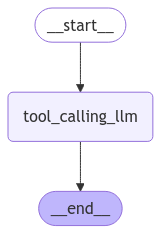

In [12]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello 👋! How can I assist you today?


In [14]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_-8891215414065162463)
 Call ID: call_-8891215414065162463
  Args:
    a: 2
    b: 3
